# 연구 2단계: 3차 함수 환경에서 노이즈와 GMM 복잡도 관계 분석

## 연구 목표
S자 형태의 더 복잡한 3차 함수 데이터 환경에서도, 1단계에서 발견한 '노이즈 수준'과 '최적 컴포넌트 개수'($k_{opt}$) 사이의 관계가 일반화될 수 있는지 검증한다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from tqdm.notebook import tqdm
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

## 1. 실험 조건 설정
모든 실험에서 동일하게 사용될 하이퍼파라미터를 정의합니다.

In [2]:
# 실험 반복 횟수 (통계적 신뢰도 확보)
N_RUNS = 30

# 테스트할 노이즈 수준 리스트
NOISE_LEVELS = [0.1, 1, 5, 10, 20, 50]

# 테스트할 GMM 컴포넌트 개수 범위
N_COMPONENTS_RANGE = range(1, 26)

# 데이터 샘플 수
N_SAMPLES = 1000

## 2. 데이터 생성 함수 정의
주어진 노이즈 수준에 따라 3차 함수 데이터를 생성하는 함수입니다.

In [3]:
def generate_3d_data(n_samples, noise_level):
    """3차 함수 데이터를 생성합니다."""
    x = np.linspace(-10, 10, n_samples)
    y = 0.05 * x**3 - 0.5 * x**2 + 0.1*x + 5 # 3차 함수 정의
    
    # 노이즈 추가
    y_noisy = y + np.random.randn(n_samples) * noise_level
    
    return np.vstack([x, y_noisy]).T

## 3. 핵심 연구 로직 실행
각 노이즈 수준에 대해 N_RUNS 만큼 실험을 반복하여, 최적의 컴포넌트 개수를 찾습니다.

In [4]:
results = []

for noise in tqdm(NOISE_LEVELS, desc="Noise Levels"):
    optimal_k_for_runs = []
    for run in tqdm(range(N_RUNS), desc=f"Runs for Noise {noise}", leave=False):
        # 데이터 생성
        data = generate_3d_data(N_SAMPLES, noise)
        
        # 각 k에 대해 GMM 학습 및 BIC 계산
        bics = []
        for k in N_COMPONENTS_RANGE:
            gmm = GaussianMixture(n_components=k, random_state=42, reg_covar=1e-6)
            gmm.fit(data)
            bics.append(gmm.bic(data))
            
        # 현재 실행(run)에서 최적의 k 찾기
        best_k = N_COMPONENTS_RANGE[np.argmin(bics)]
        optimal_k_for_runs.append(best_k)
        
    # 현재 노이즈 수준에 대한 통계치 계산
    mean_optimal_k = np.mean(optimal_k_for_runs)
    std_optimal_k = np.std(optimal_k_for_runs)
    
    results.append({
        'noise_level': noise,
        'mean_k_opt': mean_optimal_k,
        'std_k_opt': std_optimal_k,
        'all_k_opts': optimal_k_for_runs
    })

results_df_3d = pd.DataFrame(results)

Noise Levels:   0%|          | 0/6 [00:00<?, ?it/s]

Runs for Noise 0.1:   0%|          | 0/30 [00:00<?, ?it/s]

Runs for Noise 1:   0%|          | 0/30 [00:00<?, ?it/s]

Runs for Noise 5:   0%|          | 0/30 [00:00<?, ?it/s]

Runs for Noise 10:   0%|          | 0/30 [00:00<?, ?it/s]

Runs for Noise 20:   0%|          | 0/30 [00:00<?, ?it/s]

Runs for Noise 50:   0%|          | 0/30 [00:00<?, ?it/s]

## 4. 결과 분석 및 시각화

--- 3차 함수 실험 결과 ---
   noise_level  mean_k_opt  std_k_opt
0          0.1   22.633333   2.121058
1          1.0   10.433333   1.856221
2          5.0    5.700000   0.936305
3         10.0    4.333333   1.374369
4         20.0    2.433333   1.022524
5         50.0    3.066667   1.504069


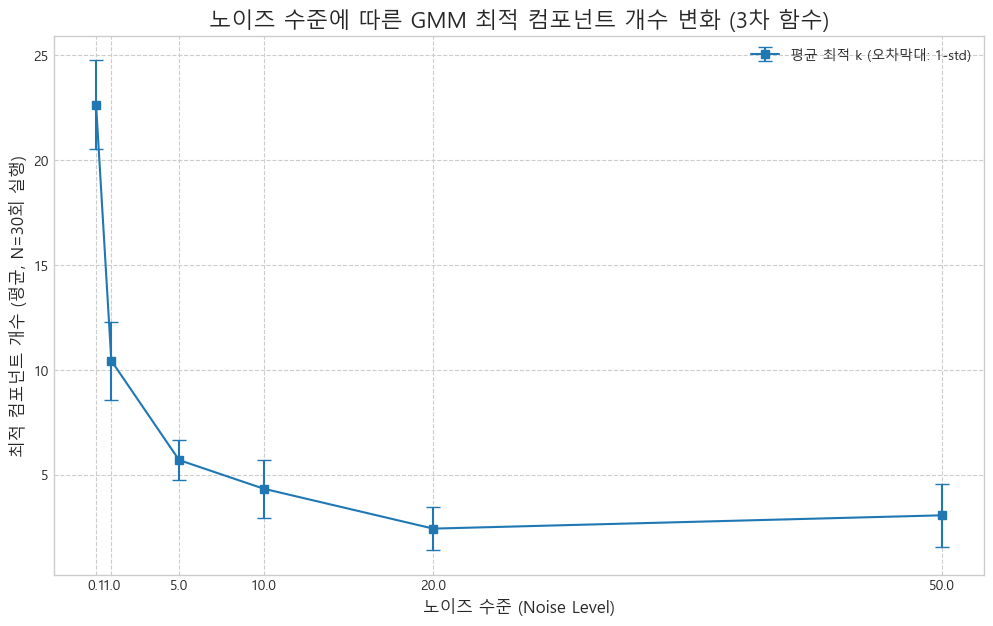

In [5]:
print("--- 3차 함수 실험 결과 ---")
print(results_df_3d[['noise_level', 'mean_k_opt', 'std_k_opt']])

plt.figure(figsize=(12, 7))

plt.errorbar(
    results_df_3d['noise_level'], 
    results_df_3d['mean_k_opt'], 
    yerr=results_df_3d['std_k_opt'],
    fmt='-s', # 마커 변경
    capsize=5,
    label='평균 최적 k (오차막대: 1-std)'
)

plt.title('노이즈 수준에 따른 GMM 최적 컴포넌트 개수 변화 (3차 함수)', fontsize=16)
plt.xlabel('노이즈 수준 (Noise Level)', fontsize=12)
plt.ylabel(f'최적 컴포넌트 개수 (평균, N={N_RUNS}회 실행)', fontsize=12)
plt.xticks(NOISE_LEVELS)
plt.grid(True, which='both', linestyle='--')
plt.legend()
plt.show()

## 5. 평가지표 상세 분석 (대표 사례)
특정 노이즈 수준에서의 대표 사례를 선정하여, 컴포넌트 개수(k)에 따른 BIC, AIC, Log-Likelihood의 변화를 상세히 분석합니다. 이를 통해 BIC가 왜 특정 k를 선택했는지 심도 있게 이해할 수 있습니다.


--- 평가지표 상세 분석 (대표 사례) ---


Analyzing Metrics for Noise 10.0:   0%|          | 0/25 [00:00<?, ?it/s]

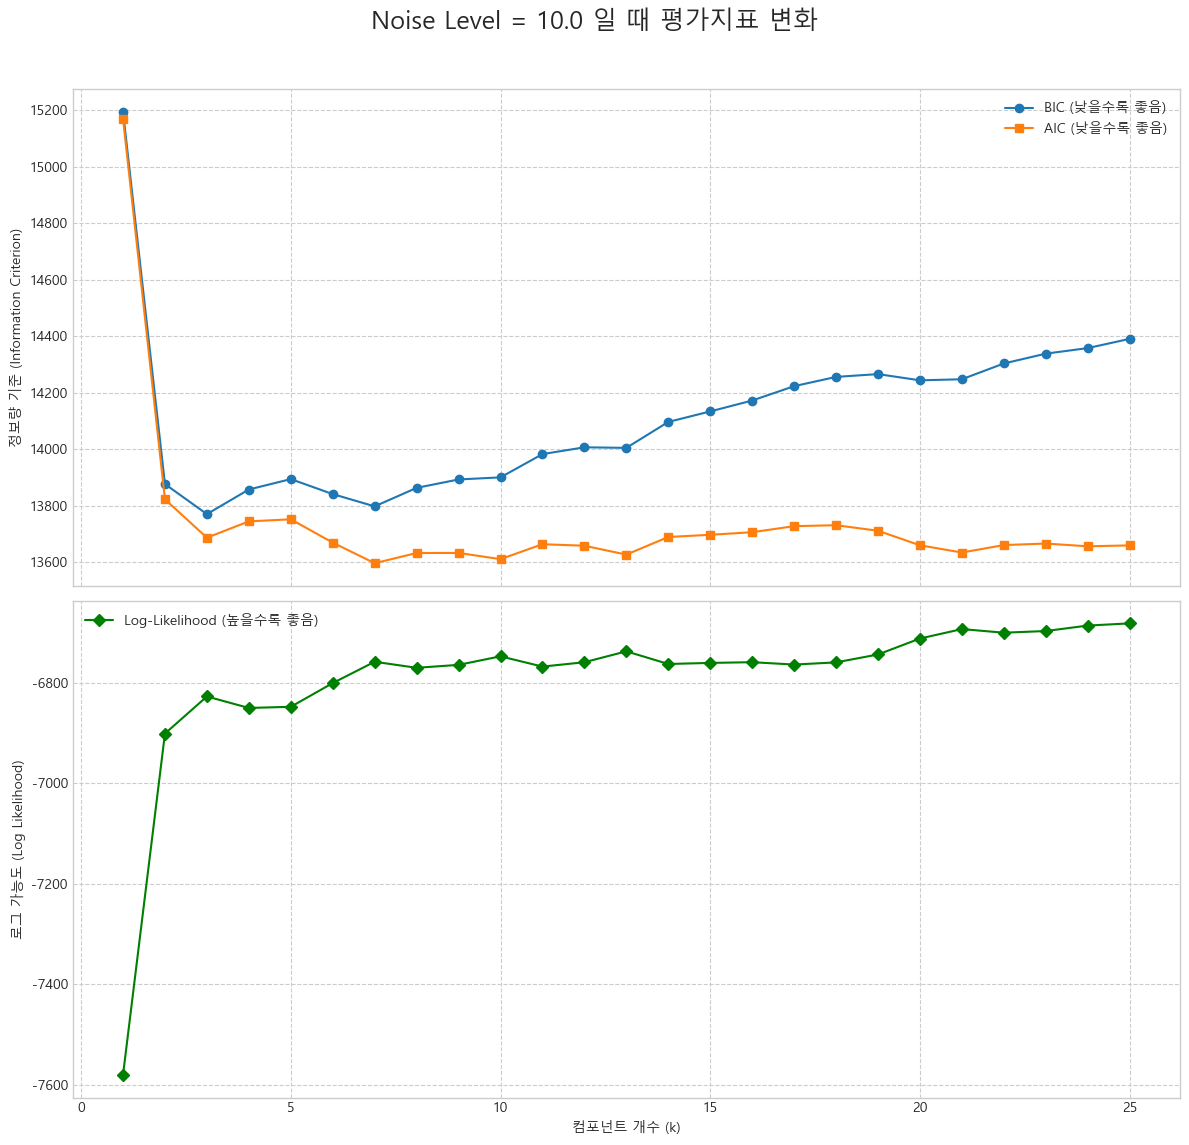

In [7]:
print("\n--- 평가지표 상세 분석 (대표 사례) ---")

# 분석할 대표 노이즈 수준 설정 (값을 바꿔가며 다른 노이즈 수준의 경향도 확인 가능)
target_noise = 10.0

# 대표 데이터 생성
data_repr = generate_3d_data(N_SAMPLES, target_noise)

# 평가지표 계산
bics_repr, aics_repr, log_likelihoods_repr = [], [], []
for k in tqdm(N_COMPONENTS_RANGE, desc=f"Analyzing Metrics for Noise {target_noise}"):
    gmm = GaussianMixture(n_components=k, random_state=42, reg_covar=1e-6)
    gmm.fit(data_repr)
    bics_repr.append(gmm.bic(data_repr))
    aics_repr.append(gmm.aic(data_repr))
    log_likelihoods_repr.append(gmm.score(data_repr) * len(data_repr))

# 시각화
fig, axes = plt.subplots(2, 1, figsize=(12, 12), sharex=True)
fig.suptitle(f'Noise Level = {target_noise} 일 때 평가지표 변화', fontsize=18)

# BIC & AIC 플롯
axes[0].plot(N_COMPONENTS_RANGE, bics_repr, 'o-', label='BIC (낮을수록 좋음)')
axes[0].plot(N_COMPONENTS_RANGE, aics_repr, 's-', label='AIC (낮을수록 좋음)')
axes[0].set_ylabel('정보량 기준 (Information Criterion)')
axes[0].legend()
axes[0].grid(True, which='both', linestyle='--')

# Log-Likelihood 플롯
axes[1].plot(N_COMPONENTS_RANGE, log_likelihoods_repr, 'D-', color='green', label='Log-Likelihood (높을수록 좋음)')
axes[1].set_xlabel('컴포넌트 개수 (k)')
axes[1].set_ylabel('로그 가능도 (Log Likelihood)')
axes[1].legend()
axes[1].grid(True, which='both', linestyle='--')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()